### 线性回归
所谓线性回归，就是将目标表示为特征的加权和，并且用截距来进行平移
- 表现形式：$\hat{y} = Xw + b$ <br>
其中，$w$是权重，$b$是偏置
- 利用平方损失来衡量预测值和真实值的差异，即：<br>
$$ L(x, b) = \frac{1}{n} \sum \frac{1}{2}(w^{T}x^{(i)} + b - y^{(i)})$$
- 线性回归有显示解，即平方损失函数的解为：
  $$ w^{*} = (X^{T}X)^{-1}X^{T}y $$
- 线性回归可以看作是单层神经网络<br>
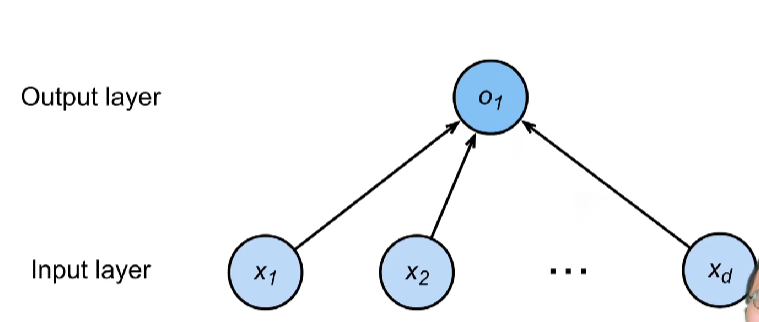
  

#### 梯度下降
通过不断沿着反梯度方向更新参数的求解
- 挑选一个初始值 
 $w_0$
- 重复迭代参数 
 $t = 1, 2, 3$
$$w_t = w_{t-1} - n*grad(L)$$
- 沿梯度方向将增加损失函数值
- 学习率：步长的超参数（需要人为设定）
<br>
由于每次计算梯度时，计算量较大，比价耗时，所以常常使用**小批量随机梯度下降**，即通过随机选取b个样本（小部分样本），来近似损失：
$$(w, b) \leftarrow (w, b) - \frac{n}{|B|}\sum \partial _{(w, b)} l^{(i)}(w, b)$$
其中，超参数为学习率和批量

#### 线性回归的实现

In [33]:
import random
import torch
from d2l import torch as d2l

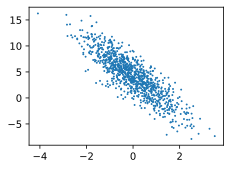

In [39]:
## 数据集的构造 ##  
#####给定 w b 和噪声  生成人造数据集#####
def create_data(w, b, num_examples):
    '''生成 y = Xw + b + 噪声'''
    X = torch.normal(0, 1, (num_examples, len(w)))  # 随机生成正态分布的 X 大小为(num_examples, len(w))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)  # 添加噪声
    return X, y.reshape((-1, 1)) # 返回  并把y设置为列向量

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = create_data(true_w, true_b, 1000)
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(),  # 要先.detach 才可以转化为numpy
               labels.detach().numpy(), 1)    

In [40]:
##### 根据批量大小来生成小批量 #####
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples)) # 生成下标列表顺序
    # 随机读取打乱下标顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)]) #注意写法
        yield features[batch_indices], labels[batch_indices] #yield相当于返回 不断地返回
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.3460,  0.3908],
        [ 1.3220,  0.3689],
        [-0.9117, -0.5852],
        [-0.5827, -0.0084],
        [-1.6646,  0.4392],
        [ 1.6722, -0.9469],
        [ 2.6757, -1.8267],
        [ 0.6354,  1.8916],
        [-0.4423, -0.0965],
        [ 0.6032,  0.1101]]) 
 tensor([[ 3.5655],
        [ 5.5935],
        [ 4.3773],
        [ 3.0733],
        [-0.6304],
        [10.7580],
        [15.7610],
        [-0.9478],
        [ 3.6607],
        [ 5.0322]])


In [43]:
##### 初始化模型参数 #####
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
##### 定义模型 #####
def linreg(X, w, b):
    '''定义线性模型'''
    return torch.matmul(X, w) + b
##### 定义损失函数 #####
def squared_loss(y_hat, y):
    '''均方损失'''
    return (y_hat - y.reshape(y_hat.shape))**2 / 2
##### 定义优化算法 #####
def sgd(params, lr, batch_size):
    ''' 小批量随机梯度下降 '''
    ''''params 为参数——w b   lr为学习率  batch_size 为批量大小'''
    with torch.no_grad():
        for param in params:
            param -= lr*param.grad / batch_size
            param.grad.zero_()  # 梯度置0 使得下一次求解时不受影响

###################
##### 训练过程 #####
###################
lr = 0.03
num_epochs = 3  #迭代次数
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # x和y是小批量损失
        # 因为l的形状是(batch_size, 1)，不是一个标量，所以要把所有元素加在一起 求梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  #梯度更新
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch{epoch + 1}, loss{float(train_l.mean()):f}')

epoch1, loss0.033377
epoch2, loss0.000121
epoch3, loss0.000052


**使用深度学习框架实现**

In [45]:
import numpy as np
import torch
from torch.utils import data  # 处理数据的包
from d2l import torch as d2l
from torch import nn  # 神经网络库  nn是神经网络的缩写

In [56]:
########## 生成数据集 ##########
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)  # 生成1000个数据集2， -3.4
########## 读取数据集——小批量读取 #########
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    ''' data_arrays 是参数  batch_size是批量大小 通过is_Train表示是否希望数据迭代器对象在每轮内打乱顺序'''
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)
batch_size = 10
data_iter = load_array((features, labels), batch_size)
## 每次通过next(iter(data_iter))来生成下一个批量的数据
next(iter(data_iter))

[tensor([[ 0.3098, -1.8212],
         [ 0.2893,  0.4076],
         [ 0.0269, -0.3224],
         [ 0.6385,  0.6110],
         [-0.5090,  0.6326],
         [-1.0303,  1.0506],
         [-0.4089, -0.5573],
         [-0.6236,  0.1068],
         [ 1.0696,  0.3676],
         [-1.0120, -1.9623]]),
 tensor([[11.0247],
         [ 3.3941],
         [ 5.3555],
         [ 3.4021],
         [ 1.0198],
         [-1.4312],
         [ 5.2687],
         [ 2.5945],
         [ 5.0944],
         [ 8.8533]])]

In [58]:
########## 定义模型 ##########
net = nn.Sequential(nn.Linear(2, 1))
### 初始化模型参数 ###
net[0].weight.data.normal_(0, 0.01)  # 通过 net[0]来访问第一层网络 通过.weight/ .bias来访问偏置
net[0].bias.data.fill_(0)            # 通过 normal_() / fill_()来重写参数值
### 定义损失函数 ###
loss = nn.MSELoss()
### 定义优化算法 ###
trainer = torch.optim.SGD(net.parameters(), lr=0.03) #parameters是模型参数 lr是学习率
########## 训练模型 ##########
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()  # 梯度清零
        l.backward()
        trainer.step()  #步进  进行模型参数更新
    l = loss(net(features), labels)
    print(f'epoch{epoch + 1}, loss{l:f}')

epoch1, loss0.000277
epoch2, loss0.000096
epoch3, loss0.000095
